RNN and LSTM Tutorial: Time Series Prediction
=============================================================================

Introduction to Recurrent Neural Networks (RNNs) and Long Short-Term Memory
(LSTMs) networks using a simple time series prediction task.

Learning Objectives:
1. Understand sequential data and why we need RNNs
2. Learn how RNNs maintain "memory" through hidden states
3. Understand the vanishing gradient problem
4. See how LSTMs solve this problem with gates and cell states
5. Compare RNN vs LSTM performance on different complexity levels

We'll start with simple sine waves, then move to more complex patterns.
This builds intuition before applying to ASL gesture recognition!

<a href="https://colab.research.google.com/github/MichiganDataScienceTeam/W26-Sign-Language-Translator/blob/main/Week%203/intro_to_pytorch_sine_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

---
# Part 1: Understanding Sequential Data

## What is sequential data?

Sequential data is data where **ORDER MATTERS**. Each data point depends on previous points.

### Examples:
- **Time series**: Stock prices, temperature readings
- **Text**: Words in a sentence (context matters!)
- **Video**: Frames showing movement over time
- **ASL signs**: Hand positions changing over time

### Why not use traditional neural networks?

Traditional neural networks treat each input independently (no memory).  
**RNNs maintain HIDDEN STATE** to remember previous inputs!

In [2]:
# Generate a sine wave
time_steps = np.linspace(0, 100, 500)   # 500 points between 0 and 100
data = np.sin(time_steps) # Create a sine wave
#data = np.sin(time_steps) + np.sin(2*time_steps) + 0.5*np.sin(4*time_steps) # Create a sine wave

# Convert to DataFrame
df = pd.DataFrame(data, columns=['value'])


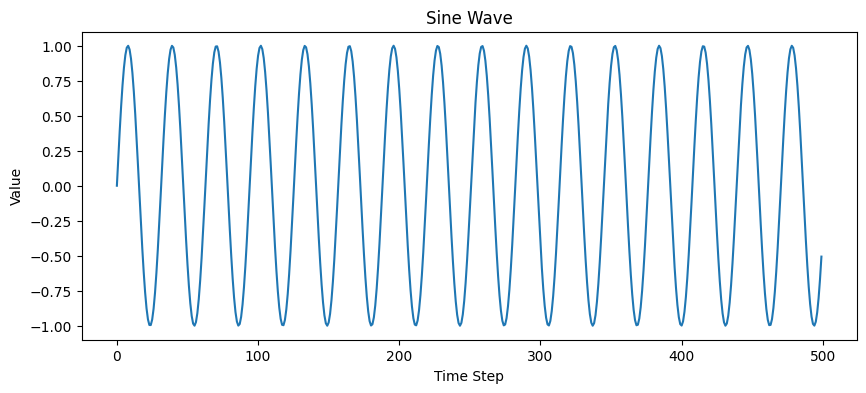

In [3]:
plt.figure(figsize=(10, 4))
plt.plot(df['value'])
plt.title("Sine Wave")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()


---
# Part 2: Data Preprocessing

## Why normalize data?

Neural networks train better when inputs are in a similar range (e.g., 0-1).

**MinMaxScaler** transforms data to [0, 1] range:

$$x_{\text{scaled}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$$

In [4]:
scaler = MinMaxScaler()

df['value'] = scaler.fit_transform(df[['value']])  # Normalize values

data = df['value'].values  # Convert to numpy array for sequence creation


---
# Part 3: Creating Sequences for RNN

## RNN Task: Predict the NEXT value given PREVIOUS values

### Example with `SEQ_LENGTH = 3`:

| Input (X) | Output (y) |
|-----------|------------|
| [0.1, 0.2, 0.3] | 0.4 |
| [0.2, 0.3, 0.4] | 0.5 |
| [0.3, 0.4, 0.5] | 0.6 |

This is called **"sliding window"** - we slide a window of length `SEQ_LENGTH` across the time series, creating many training examples.
---

In [5]:
# Create train / test data

def create_sequences(data, seq_length):
  xs, ys = [], []
  for i in range(len(data) - seq_length):
    x = data[i:i+seq_length] # Sequence of length `seq_length`
    y = data[i+seq_length] # Label is the next value
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

SEQ_LENGTH = 20 # Number of past time steps to look at

X, y = create_sequences(data, SEQ_LENGTH)

# Part 4: Train/Test Split

## Why split data?
- **Training set**: Used to learn patterns (80%)
- **Test set**: Used to evaluate performance on unseen data (20%)

### Important: `shuffle=False` for time series!

We don't shuffle because we want to test on **future data**.  
Shuffling would leak information from the future into training.

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert arrays to PyTorch tensors
X_train = torch.Tensor(X_train).unsqueeze(-1) # Shape: (batch, seq, input_size)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test).unsqueeze(-1)
y_test = torch.Tensor(y_test)


---
# Part 5: Building the RNN Model

## How RNNs Work:

**Traditional NN**: `input → output` (no memory)

**RNN**: Maintains **HIDDEN STATE** that carries information from previous steps
```
Time step 1: input₁ + h₀ → RNN → h₁  (hidden state updated)
Time step 2: input₂ + h₁ → RNN → h₂  (remembers step 1!)
Time step 3: input₃ + h₂ → RNN → h₃  (remembers steps 1 & 2!)
...
Final: hₙ → Fully Connected Layer → prediction
```

The hidden state is like **SHORT-TERM MEMORY**.

## Key Parameters:
- `input_size`: Number of features per time step (1 for our sine wave)
- `hidden_size`: Size of hidden state (more = more memory capacity)
- `num_layers`: Stack multiple RNN layers (deeper = more complex patterns)
- `batch_first`: If True, input shape is (batch, seq, features)

In [7]:
class RNN_Model(nn.Module):
  def __init__(self, input_size=1, hidden_size=64, num_layers=1):
    super(RNN_Model, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    #self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.rnn(x)         # RNN output for all time steps
    out = out[:, -1, :]          # Take output from the last time step
    return self.fc(out)          # Pass through linear layer

# Instantiate the model
model = RNN_Model(num_layers=2)


---
# Part 6: Training Configuration

## Training Components:

### 1. Loss Function (Criterion):
**MSE (Mean Squared Error)** - measures prediction error

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (\text{predicted}_i - \text{actual}_i)^2$$

### 2. Optimizer:
**Adam** - adaptive learning rate optimizer  
Automatically adjusts learning rate for each parameter

### 3. Training Loop:
For each epoch:
  1. **Forward pass**: Make predictions
  2. **Calculate loss**: How wrong are we?
  3. **Backward pass**: Calculate gradients
  4. **Update weights**: Improve model

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 100

---
# Part 7: Training the RNN

Now let's train the model on our simple sine wave!

In [9]:
losses = []

for epoch in range(EPOCHS):
  model.train()
  output = model(X_train)
  loss = criterion(output.squeeze(), y_train)  # Compute loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if (epoch + 1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")


Epoch [10/100], Loss: 0.0460
Epoch [20/100], Loss: 0.0504
Epoch [30/100], Loss: 0.0214
Epoch [40/100], Loss: 0.0034
Epoch [50/100], Loss: 0.0024
Epoch [60/100], Loss: 0.0007
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


---
# Part 8: Evaluating RNN Performance

Let's see how well our RNN learned the sine wave pattern!

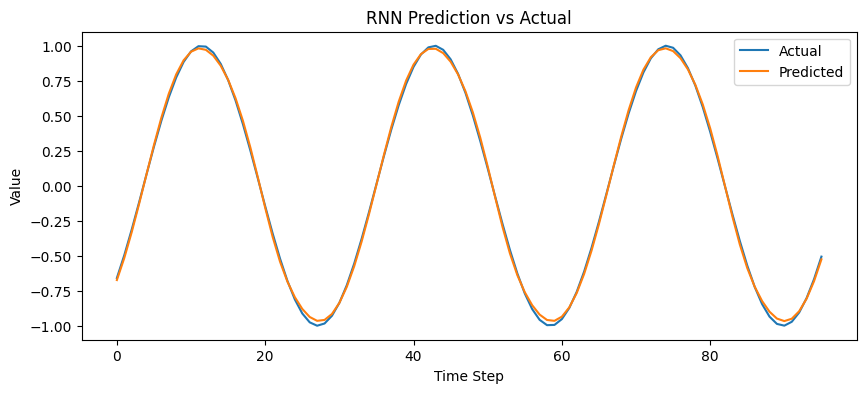

In [10]:
model.eval()
with torch.no_grad():
  predictions = model(X_test).squeeze().numpy() # Predict on test set

# Inverse transform to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1))


# Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.title("RNN Prediction vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()


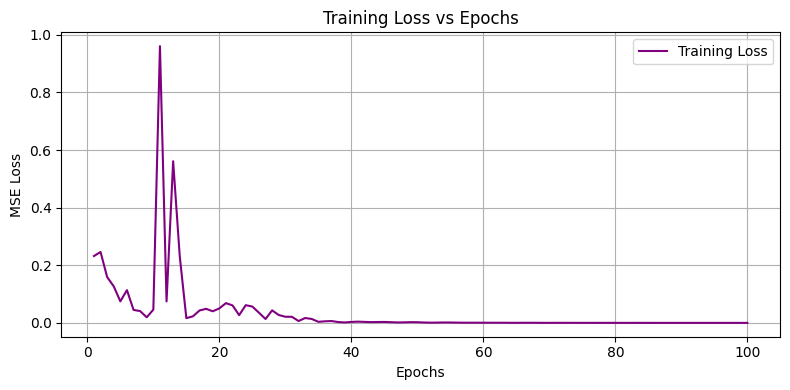

In [11]:
# Plot the loss at each epoch to visualize model convergence
plt.figure(figsize=(8, 4))
plt.plot(range(1, 100 + 1), losses, label='Training Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss vs Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Different Sine Wave

---
# Part 9: More Complex Pattern

## Challenge: Can RNN learn a more complex pattern?

### New pattern: Sum of 4 different sine waves
- Different **frequencies** (rates of oscillation)
- Different **amplitudes** (heights)

This is more realistic: real-world signals are often combinations of multiple patterns  
(e.g., ASL signs have multiple movement components).

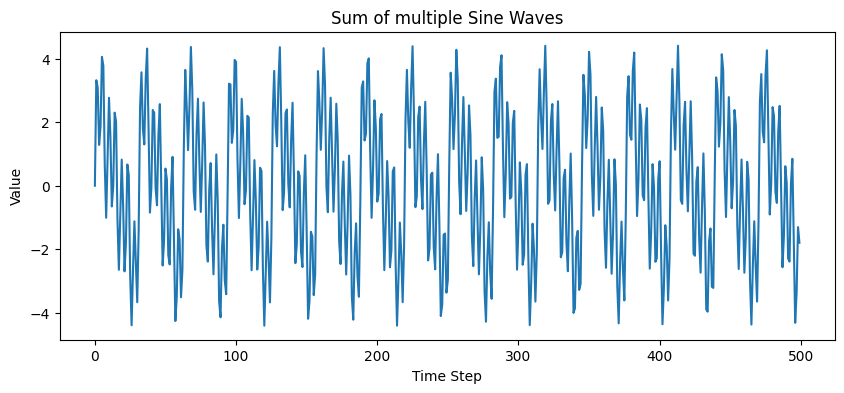

In [12]:
time_steps = np.linspace(0, 100, 500)   # 500 points between 0 and 100
data = 2*np.sin(time_steps) + np.sin(2*time_steps) + np.sin(3*time_steps) + 2*np.sin(7*time_steps)

# Convert to DataFrame
df = pd.DataFrame(data, columns=['value'])

plt.figure(figsize=(10, 4))
plt.plot(df['value'])
plt.title("Sum of multiple Sine Waves")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.show()

---
# Part 10: Prepare Complex Pattern Data

In [13]:
# Create train / test data
scaler = MinMaxScaler()
df['value'] = scaler.fit_transform(df[['value']])  # Normalize values
data = df['value'].values  # Convert to numpy array for sequence creation
def create_sequences(data, seq_length):
  xs, ys = [], []
  for i in range(len(data) - seq_length):
    x = data[i:i+seq_length] # Sequence of length `seq_length`
    y = data[i+seq_length] # Label is the next value
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

SEQ_LENGTH = 20 # Number of past time steps to look at
X, y = create_sequences(data, SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = torch.Tensor(X_train).unsqueeze(-1) # Shape: (batch, seq, input_size)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test).unsqueeze(-1)
y_test = torch.Tensor(y_test)

---
# Part 11: Train RNN on Complex Pattern

In [14]:
# Instantiate the model as before
model = RNN_Model(num_layers=2)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 100

losses = []

for epoch in range(EPOCHS):
  model.train()
  output = model(X_train)
  loss = criterion(output.squeeze(), y_train)  # Compute loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if (epoch + 1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.0430
Epoch [20/100], Loss: 0.0345
Epoch [30/100], Loss: 0.0169
Epoch [40/100], Loss: 0.0120
Epoch [50/100], Loss: 0.0038
Epoch [60/100], Loss: 0.0017
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0001


---
# Part 12: Evaluate RNN on Complex Pattern

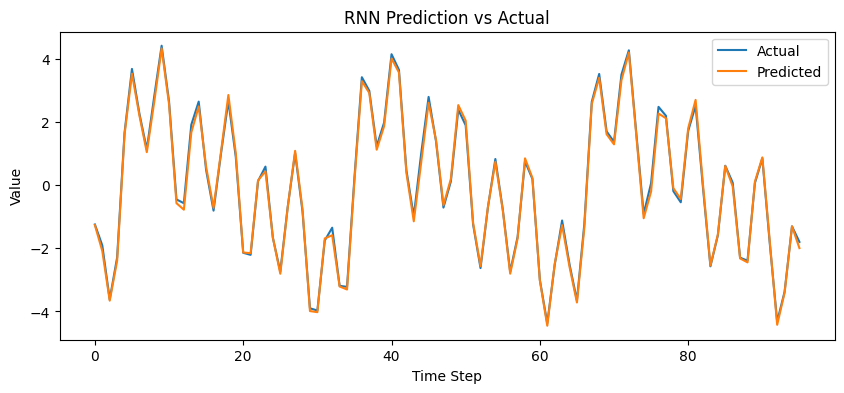

In [15]:
# test model
model.eval()
with torch.no_grad():
  predictions = model(X_test).squeeze().numpy() # Predict on test set

# Inverse transform to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1))


# Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.title("RNN Prediction vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

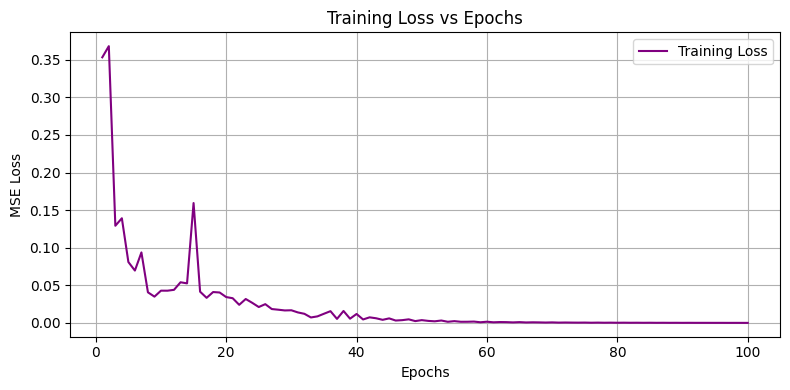

In [16]:

# Plot the loss at each epoch to visualize model convergence
plt.figure(figsize=(8, 4))
plt.plot(range(1, 100 + 1), losses, label='Training Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training Loss vs Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---
# Part 13: The Vanishing Gradient Problem

## Why did RNN struggle with the complex pattern?

### THE VANISHING GRADIENT PROBLEM:

When training deep networks (or long sequences), gradients can become **extremely small** as they backpropagate through many layers/time steps.

### During backpropagation:
- Gradients are multiplied many times
- Small numbers multiplied repeatedly → vanishes
- Example: $0.5 \times 0.5 \times 0.5 \times ... \text{ (20 times)} \approx 0.000001$

### Result:
- Early time steps receive almost no gradient signal
- Model can't learn long-term dependencies
- RNN "forgets" information from many steps ago

### Solution: LSTM (Long Short-Term Memory) networks!

LSTMs use **GATES** and **CELL STATE** to maintain information over long sequences.

---
# Part 14: Long Short-Term Memory (LSTM) Networks

## LSTM Key Idea: CELL STATE + GATES

### Components:

#### 1. **Cell State (c)**: "Long-term memory"
   - Flows through the network with minimal modifications

#### 2. **Hidden State (h)**: "Short-term memory" - working memory
   - Updated at each time step

#### 3. **Three Gates** (control information flow):

   **a) FORGET GATE**: What to remove from cell state?
   - "Should I forget the previous pattern I saw?"

   **b) INPUT GATE**: What new information to add?
   - "What parts of the current input should I remember?"

   **c) OUTPUT GATE**: What to output to next layer?
   - "What should I pass to the next time step?"

### Benefits:
- Information can flow with minimal interference
- Gradients flow more easily during backpropagation
- Can learn both short-term and long-term dependencies!

In [17]:
# Can also pass input sequence through a long short-term memory RNN

# This results in similar performance in this mock problem, but
# in general tends to have more stable converge due to mitigating
# the vanishing gradient problem

class LSTM_Model(nn.Module):
  def __init__(self, input_size=1, hidden_size=64, num_layers=1):
    super(LSTM_Model, self).__init__()
    # LSTM cells can directly replace standard RNN
    #self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, (h,c) = self.lstm(x)    # LSTM output for all time steps
                                 # one additional output: cell state (long-term)
    out = out[:, -1, :]          # Take output from the last time step
    return self.fc(out)          # Pass through linear layer

# Instantiate the model
model = LSTM_Model(num_layers=2)

---
# Part 15: Train LSTM on Complex Pattern

In [18]:

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 100

losses = []

for epoch in range(EPOCHS):
  model.train()
  output = model(X_train)
  loss = criterion(output.squeeze(), y_train)  # Compute loss

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if (epoch + 1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")

Epoch [10/100], Loss: 0.1499
Epoch [20/100], Loss: 0.0677
Epoch [30/100], Loss: 0.0629
Epoch [40/100], Loss: 0.0610
Epoch [50/100], Loss: 0.0591
Epoch [60/100], Loss: 0.0568
Epoch [70/100], Loss: 0.0533
Epoch [80/100], Loss: 0.0467
Epoch [90/100], Loss: 0.0470
Epoch [100/100], Loss: 0.0385


---
# Part 16: Evaluate LSTM Performance

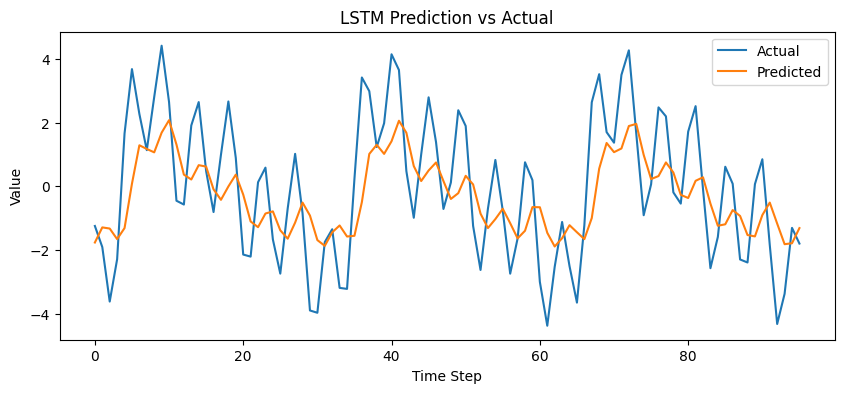

In [19]:
# test model
model.eval()
with torch.no_grad():
  predictions = model(X_test).squeeze().numpy() # Predict on test set

# Inverse transform to original scale
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inv = scaler.inverse_transform(predictions.reshape(-1, 1))


# Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.title("LSTM Prediction vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

---
# Summary and Key Takeaways

## What We Learned:

### 1. Sequential Data requires models with memory
- Order matters in time series, text, video, ASL signs
- Traditional NNs treat each input independently

### 2. RNNs maintain hidden state to remember previous inputs
- Hidden state updated at each time step
- Allows model to use context from earlier in sequence

### 3. VANISHING GRADIENT PROBLEM limits RNNs
- Gradients become very small over long sequences
- Model can't learn long-term dependencies
- RNN struggles with complex patterns

### 4. LSTMs solve this with gates and cell state
- Cell state = long-term memory highway
- Gates control information flow (forget/input/output)
- Can learn both short and long-term dependencies
- Better performance on complex patterns!

### 5. SOME DIFFERENCES:

| Aspect | RNN | LSTM |
|--------|-----|------|
| Complexity | Simpler | More complex |
| Parameters | Fewer | ~4x more |
| Training Speed | Faster | Slower |
| Performance | Good for simple | Better for complex |
| Long-term memory | Struggles | Excels |

## When to use which?
- Simple patterns, short sequences → RNN
- Complex patterns, long sequences → LSTM

---

## NEXT STEPS FOR ASL:

Our sine waves had **1 feature** per time step (the value).

**ASL videos** have **42 features** per time step:  
`21 landmarks × 2 coordinates (x, y)`

### Same principles apply!
```
Simple pattern (sine)      → RNN works okay
Complex pattern (4 sines)  → LSTM works a bit better
ASL gestures              → LSTM is the best!
                             (complex movements over time)
```

**Next**: Apply these concepts to ASL gesture recognition!